#### 项目说明
该项目采用传统图像处理算法，执行车牌识别任务，可借此将常用的图像处理算法串起来，方便学习。<br>

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看AI Studio环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions.<br>

如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:<br>
!mkdir /home/aistudio/external-libraries <br>
!pip install beautifulsoup4 -t /home/aistudio/external-libraries <br>
 
同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: <br>
import sys  <br>
sys.path.append('/home/aistudio/external-libraries')




In [1]:
import cv2
import zipfile
import rarfile
import numpy as np
from numpy.linalg import norm
import sys
import os
import json
from PIL import Image, ImageTk
from globalObject import *
from matplotlib import pyplot as plt
from matplotlib.font_manager import  FontProperties 
# !pip install unrar -t /home/aistudio/external-libraries
sys.path.append('/home/aistudio/external-libraries')

# fname中选择一个你本机查询出来的字体 若没有中文字体则需要你本人手动安装  
font = FontProperties(fname=r"/home/aistudio/work/simhei.ttf")
# plt.rcParams['font.family'] = [font]   #用来正常显示中文
# plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

HomePath = r"/home/aistudio/"
WorkPath = r"/home/aistudio/work/"
DataPath = r"/home/aistudio/data/"
# WorkPath = r"/home/aistudio/work/"
src_path = r"/home/aistudio/work/imgs.zip" # 原始数据集路径
target_path = DataPath        # 要解压的路径 

SZ = 20  # 训练图片长宽
MAX_WIDTH = 1000  # 原始图片最大宽度
Min_Area = 1000  # 车牌区域允许最小面积
PROVINCE_START = 1000  #加上此值将汉字标签与英文数字的ASCII相区分

# 数据集rar包解压
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至data/imgs目录下
    ''' 
    if(not os.path.isdir(target_path+'imgs')):    
        zf = zipfile.ZipFile(src_path, 'r')
        for file in zf.namelist():
            zf.extract(file, target_path)
        zf.close()
        # z.extractall(path=target_path)        
    else:
        print("文件已解压")

def unrar_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的rar包解压至data/imgs目录下
    ''' 
    if(not os.path.isdir(target_path)):
        rf = rarfile.RarFile(src_path,'r')
        rf.extractall(target_path) 
        rf.close()      
    else:
        print("文件已解压")


# 读取图片文件
def imreadex(filename):
    # return cv2.imread(filename)
    #用以下方法可以解决路径中有汉字的问题
    return cv2.imdecode(np.fromfile(filename, dtype=np.uint8), cv2.IMREAD_COLOR)

    # 从指定的内存缓存中读取数据，并把数据转换(解码)成图像格式

# 保证坐标非负
def point_limit(point):
    if point[0] < 0:
        point[0] = 0
    if point[1] < 0:
        point[1] = 0

# 根据设定的阈值和图片直方图，找出波峰，用于分隔字符
def find_waves(threshold, histogram):
    up_point = -1  # 上升点
    is_peak = False
    if histogram[0] > threshold:
        up_point = 0
        is_peak = True
    wave_peaks = []
    for i, x in enumerate(histogram):
        if is_peak and x < threshold:
            if i - up_point > 2:
                is_peak = False
                wave_peaks.append((up_point, i))
        elif not is_peak and x >= threshold:
            is_peak = True
            up_point = i
    if is_peak and up_point != -1 and i - up_point > 4:
        wave_peaks.append((up_point, i))
    return wave_peaks


# 根据找出的波峰，分隔图片，从而得到逐个字符图片
def seperate_card(img, waves):
    part_cards = []
    for wave in waves:
        part_cards.append(img[:, wave[0]:wave[1]])
    return part_cards

[ WARN:0@0.140] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('.\img\empty.png'): can't open/read file: check file path/integrity


In [2]:
#父类模型，具有加载保存功能
class StatModel(object):
    def load(self, fn):
        self.model = self.model.load(fn)

    def save(self, fn):
        self.model.save(fn)

#支持向量机类，可以训练模型和测试模型
class SVM(StatModel):  #SVM继承自StatModel
    def __init__(self, C=1, gamma=0.5):
        self.model = cv2.ml.SVM_create()
        self.model.setGamma(gamma)
        self.model.setC(C)
        self.model.setKernel(cv2.ml.SVM_RBF)
        self.model.setType(cv2.ml.SVM_C_SVC)

    # 训练svm
    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    # 字符识别
    def predict(self, samples):
        r = self.model.predict(samples)
        return r[1].ravel()

In [3]:
# 根据图片中心矩对图片进行校正
def deskew(img):
    m = cv2.moments(img)  #计算图像中的中心矩(最高到三阶)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * SZ * skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

# 提取图像的方向梯度直方图，自编函数提取HOG特征
def preprocess_hog(digits):
    samples = []
    for img in digits:
        gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
        mag, ang = cv2.cartToPolar(gx, gy)# cv2.cartToPolar()会同时得到幅度和相位,此函数也是直角坐标转换为极坐标的函数
        bin_n = 16
        bin = np.int32(bin_n * ang / (2 * np.pi))
        bin_cells = bin[:10, :10], bin[10:, :10], bin[:10, 10:], bin[10:, 10:]
        mag_cells = mag[:10, :10], mag[10:, :10], mag[:10, 10:], mag[10:, 10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]#将列表变为直方图，bin_n=16
        # bincount功能是将一个序列变为直方图，其中b是序列，m是对应的权重，以下是其简单用法
        # x = np.array([7, 6, 2, 1, 4])
        # # 索引0出现了0次，索引1出现了1次......索引5出现了0次......
        # np.bincount(x)
        # # 输出结果为：array([0, 1, 1, 0, 1, 0, 1, 1])
        hist = np.hstack(hists) #hist包含4个元素，每个元素是16维的

        # 特征归一化
        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps
        samples.append(hist)
    return np.float32(samples)


# 不能保证包括所有省份,偶数索引是拼音，奇数索引是汉字
provinces = [
    "zh_chuan", "川",
    "zh_e", "鄂",
    "zh_gan", "赣",
    "zh_gan1", "甘",
    "zh_gui", "贵",
    "zh_gui1", "桂",
    "zh_hei", "黑",
    "zh_hu", "沪",
    "zh_ji", "冀",
    "zh_jin", "津",
    "zh_jing", "京",
    "zh_jl", "吉",
    "zh_liao", "辽",
    "zh_lu", "鲁",
    "zh_meng", "蒙",
    "zh_min", "闽",
    "zh_ning", "宁",
    "zh_qing", "靑",
    "zh_qiong", "琼",
    "zh_shan", "陕",
    "zh_su", "苏",
    "zh_sx", "晋",
    "zh_wan", "皖",
    "zh_xiang", "湘",
    "zh_xin", "新",
    "zh_yu", "豫",
    "zh_yu1", "渝",
    "zh_yue", "粤",
    "zh_yun", "云",
    "zh_zang", "藏",
    "zh_zhe", "浙"
]

In [4]:
#车牌识别类，此类有两个模型对象成员，用于英文数字和汉字的识别
class CardPredictor:
    # def __init__(self,rightWindow):
    def __init__(self):
        # 车牌识别的部分参数保存在js中，便于根据图片分辨率做调整
        # self.stepFlag = False
        self.stepFlag = True
        # self.rightWindow=rightWindow
        f = open(HomePath + r'/config.js')
        j = json.load(f)
        for c in j["config"]:
            if c["open"]:
                # print('config.open:',c["open"])
                self.cfg = c.copy()
                break
        else:
            raise RuntimeError('没有设置有效配置参数')
        # 识别英文字母和数字的模型
        self.model = SVM(C=1, gamma=0.5)
        # 识别中文的模型
        self.modelchinese = SVM(C=1, gamma=0.5)
    def __del__(self):
        self.save_traindata()
    #生成训练集，并训练模型
    def train_svm(self):
        #训练识别英文数字模型
        chars_train = []
        chars_label = []
        for root, dirs, files in os.walk(DataPath + r"imgs/train/chars2"):  #返回目录的一个三元组(root,dirs,files)
            if len(os.path.basename(root)) > 1: #获取对应路径下文件的名字
                continue
            root_int = ord(os.path.basename(root))  #返回数字字符对应的 ASCII 数值，对应子文件夹名称
            for filename in files:
                filepath = os.path.join(root, filename)
                digit_img = cv2.imread(filepath)
                digit_img = cv2.cvtColor(digit_img, cv2.COLOR_BGR2GRAY)
                chars_train.append(digit_img)
                # chars_label.append(1)
                chars_label.append(root_int)

        chars_train = list(map(deskew, chars_train))  #调用deskew函数对所用训练图片进行校正
        chars_train = preprocess_hog(chars_train)     #提取训练图片的HOG特征
        # chars_train = chars_train.reshape(-1, 20, 20).astype(np.float32)
        chars_label = np.array(chars_label)
        print('训练集维度(英文数字)：',chars_train.shape)
        self.model.train(chars_train, chars_label)

        #训练识别汉字模型
        chars_train = []
        chars_label = []
        for root, dirs, files in os.walk(DataPath + r"imgs/train/charsChinese"):
            if not os.path.basename(root).startswith("zh_"):
                continue
            pinyin = os.path.basename(root)
            index = provinces.index(pinyin) + PROVINCE_START + 1  # 1是拼音对应的汉字,与数字的ASCII码区分开来
            # print(provinces.index(pinyin),index)
            for filename in files:
                filepath = os.path.join(root, filename)
                digit_img = cv2.imread(filepath)
                digit_img = cv2.cvtColor(digit_img, cv2.COLOR_BGR2GRAY)
                chars_train.append(digit_img)
                # chars_label.append(1)
                chars_label.append(index)
        chars_train = list(map(deskew, chars_train))
        #显示抗扭斜处理前后对比图
        # filename="debug_chineseMat63.jpg"
        # root="train\\charsChinese\\zh_cuan"
        # filepath = os.path.join(root, filename)
        # digit_img = cv2.imread(filepath)
        # p1 = cv2.cvtColor(digit_img, cv2.COLOR_BGR2GRAY)
        # p2= deskew(p1)
        # cv2.imshow("before deskew",p1)
        # cv2.imshow("after deskew", p2)
        # cv2.waitKey(0)
        chars_train = preprocess_hog(chars_train)
        # chars_train = chars_train.reshape(-1, 20, 20).astype(np.float32)
        chars_label = np.array(chars_label)
        print('训练集维度(汉字)：',chars_train.shape)
        self.modelchinese.train(chars_train, chars_label)
        # self.save_traindata()#保存训练好的两个模型

    #保存训练好的模型
    def save_traindata(self):
        if not os.path.exists(WorkPath + r"svm.dat"):
            self.model.save(WorkPath + r"svm.dat")
        if not os.path.exists(WorkPath + r"svmchinese.dat"):
            self.modelchinese.save(WorkPath + r"svmchinese.dat")

    # 利用色彩信息精确定位
    def accurate_place(self, card_img_hsv, limit1, limit2, color):
        row_num, col_num = card_img_hsv.shape[:2]
        xl = col_num
        xr = 0
        yh = 0
        yl = row_num
        # col_num_limit = self.cfg["col_num_limit"]
        row_num_limit = self.cfg["row_num_limit"]
        col_num_limit = col_num * 0.8 if color != "green" else col_num * 0.5  # 绿色有渐变
        for i in range(row_num):
            count = 0
            for j in range(col_num):
                H = card_img_hsv.item(i, j, 0)
                S = card_img_hsv.item(i, j, 1)
                V = card_img_hsv.item(i, j, 2)
                if limit1 < H <= limit2 and 34 < S and 46 < V:
                    count += 1
            if count > col_num_limit:
                if yl > i:
                    yl = i
                if yh < i:
                    yh = i
        for j in range(col_num):
            count = 0
            for i in range(row_num):
                H = card_img_hsv.item(i, j, 0)
                S = card_img_hsv.item(i, j, 1)
                V = card_img_hsv.item(i, j, 2)
                if limit1 < H <= limit2 and 34 < S and 46 < V:
                    count += 1
            if count > row_num - row_num_limit:
                if xl > j:
                    xl = j
                if xr < j:
                    xr = j
        return xl, xr, yh, yl

    # 结果显示
    def stepShow(self,img_show, text2="处理结果图", RGB=True):
        '''
        :param img_show: 需要显示的图像
        :param text2: 图像文字说明
        :param RGB: 是否转换成RGB,默认转换
        :return: img_result
        '''
        # global picSize, img_result, myWindow
        plt.title(text2,fontproperties = font)
        img = img_show.copy()
        if len(img.shape) > 2 and RGB:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
        else:
            plt.imshow(img,cmap="gray") 
        plt.show()

    #进行车牌检测、分割、识别
    def predict(self, car_pic):
        if os.path.exists(WorkPath + r"svm.dat"):  # 如果已存在训练好的模型，则不再训练
            self.model.load(WorkPath + r"svm.dat")  # 加载已训练的识别英文数字的SVM模型
        else:
            # showwarning(title='警告', message='未训练好的识别模型，请先训练模型！')
            print("警告：未训练好的识别模型，请先训练模型！")
            return
        if os.path.exists(WorkPath + r"svmchinese.dat"): #如果已存在训练好的模型，则不再训练
            self.modelchinese.load(WorkPath + r"svmchinese.dat")  #加载识别汉字的SVM模型
        else:
            # showwarning(title='警告', message='未训练好的识别模型，请先训练模型！')
            print("警告：未训练好的识别模型，请先训练模型！")
            return
        img=car_pic.copy()
        pic_hight, pic_width = img.shape[:2]
        if pic_width > MAX_WIDTH:
            resize_rate = MAX_WIDTH / pic_width  #获得缩放比例
            img = cv2.resize(img, (MAX_WIDTH, int(pic_hight * resize_rate)), interpolation=cv2.INTER_AREA)

        blur = self.cfg["blur"]
        # 高斯去噪
        if blur > 0:
            img = cv2.GaussianBlur(img, (blur, blur),0)  # 图片分辨率调整
        colorImg = img   #colorImg是高斯模糊后的RGB图，后面需要根据颜色来判断是否是车牌

        # 分步显示结果
        if self.stepFlag:
            print("1.图像预处理就是去除图像中的噪声、模糊、光照不均匀、遮挡等问题。 \n此步骤是对图像做高斯去噪处理")
            self.stepShow(colorImg, "高斯去噪后的图像")
            self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # 分步显示结果
        if self.stepFlag:
            print("2.车牌检测的步骤包括图像灰度化、获得差分图、差分图二值化、锐化滤波及寻找图像轮廓。"
                                             "\n此步骤是对图像进行灰度处理")
            self.stepShow(img, "灰度化图像")                                 
            self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

        # cv2.imshow("gray_img", img)
        # cv2.waitKey(0)
        # ===========车牌检测===========
        kernel = np.ones((20, 20), np.uint8)
        #灰度开运算差分图
        img_opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

        # 分步显示结果
        if self.stepFlag:
            print("2.车牌检测的步骤包括图像灰度化、获得差分图、差分图二值化、锐化滤波及寻找图像轮廓。"
                                             "\n此步骤是对灰度图像开运算结果")
            self.stepShow(img_opening, "开运算图像")
            self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

        img_opening = cv2.addWeighted(img, 1, img_opening, -1, 0);
        # 分步显示结果
        if self.stepFlag:
            print("2.车牌检测的步骤包括图像灰度化、获得差分图、差分图二值化、锐化滤波及寻找图像轮廓。"
                                             "\n差分图像是将原灰度图像减去开运算图像得到的结果")
            self.stepShow(img_opening, "差分灰度图像")
            self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

        # 差分图二值化
        ret, img_thresh = cv2.threshold(img_opening, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # 分步显示结果
        if self.stepFlag:
            print("2.车牌检测的步骤包括图像灰度化、获得差分图、差分图二值化、锐化滤波及寻找图像轮廓。"
                                             "\n此步骤是将差分图二值化")
            self.stepShow(img_thresh, "差分图二值化图像")
            self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

        #锐化滤波，寻找图像轮廓
        img_edge = cv2.Canny(img_thresh, 100, 200)
        # 分步显示结果
        if self.stepFlag:
            print("2.车牌检测的步骤包括图像灰度化、获得差分图、差分图二值化、锐化滤波及寻找图像轮廓。"
                                             "\n此步骤是将二值化的差分图进行锐化滤波")
            self.stepShow(img_edge, "二值差分图像的锐化")
            self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

        # 使用开运算和闭运算去除图像轮廓中的噪声点，并连接断点
        kernel = np.ones((self.cfg["morphologyr"], self.cfg["morphologyc"]), np.uint8)
        img_edge1 = cv2.morphologyEx(img_edge, cv2.MORPH_CLOSE, kernel)
        img_edge2 = cv2.morphologyEx(img_edge1, cv2.MORPH_OPEN, kernel)
        # 分步显示结果
        if self.stepFlag:
            print("2.车牌检测的步骤包括图像灰度化、获得差分图、差分图二值化、锐化滤波及寻找图像轮廓。"
                                             "\n此步骤是使用开运算和闭运算对二值差分图像进行处理，去除图像轮廓中的噪声点，并连接断点")
            self.stepShow(img_edge2, "形态学处理后的二值差分图像")
            self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

        # 查找轮廓图中的矩形区域，作为车牌候选区域
        contours, hierarchy = cv2.findContours(img_edge2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = [cnt for cnt in contours if cv2.contourArea(cnt) > Min_Area]
        print('len(contours)', len(contours))
        colorImg1=colorImg.copy()
        cv2.drawContours(colorImg1,contours,-1,(255,255,255),3)
        # 分步显示结果
        if self.stepFlag:
            print("2.车牌检测的步骤包括图像灰度化、获得差分图、差分图二值化、锐化滤波及寻找图像轮廓。"
                                             "\n此步骤是查找轮廓图中的连通区域，作为车牌候选区域")
            self.stepShow(colorImg1, "车牌候选区域")
            self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

        # 根据长宽比排除不是车牌的矩形区域
        car_contours = []
        for cnt in contours:
            rect = cv2.minAreaRect(cnt)    #返回一个外接矩形的（最小外接矩形的中心（x，y），（宽度，高度），旋转角度）
            area_width, area_height = rect[1]
            if area_width < area_height:   #如果区域的宽度小于高度，则交换宽度与高度
                area_width, area_height = area_height, area_width
            wh_ratio = area_width / area_height
            # print(wh_ratio)
            # 要求矩形区域长宽比在2到5.5之间，2到5.5是车牌的长宽比，其余的矩形排除
            if wh_ratio > 2 and wh_ratio < 5.5:
                car_contours.append(rect)
                box = cv2.boxPoints(rect) #获得矩形的四个顶点坐标
                box = np.int0(box)
                colorImg1 = colorImg.copy()
                colorImg1 = cv2.drawContours(colorImg1, [box], -1, (255, 255, 255), 3)
                # 分步显示结果
                if self.stepFlag:
                    print("2.车牌检测的步骤包括图像灰度化、获得差分图、差分图二值化、锐化滤波及寻找图像轮廓。"
                                                     "\n此步骤是根据矩形区域长宽比（2~5.5之间是车牌的长宽比）来筛选车牌候选区域")
                    self.stepShow(colorImg1, "筛选后的车牌候选区域")
                    self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

        # print(len(car_contours))

        # print("精确定位")
        card_imgs = []
        # 去除候选区域的仿射畸变，以便使用颜色定位
        for rect in car_contours:
            if rect[2] > -1 and rect[2] < 1:  # 创造角度，使得左、高、右、低拿到正确的值
                angle = 1
            else:
                angle = rect[2]
            rect = (rect[0], (rect[1][0] + 1, rect[1][1] + 1), angle)  # 扩大范围，避免车牌边缘被排除,原来是加5

            box = cv2.boxPoints(rect)
            # print("box_ :" +str(box) )
            #初始化区域的上下左右四个点，并获得最左最右最上最下的四个点坐标
            heigth_point = right_point = [0, 0]
            left_point = low_point = [pic_width, pic_hight]
            for point in box:
                if left_point[0] > point[0]:
                    left_point = point
                if low_point[1] > point[1]:
                    low_point = point
                if heigth_point[1] < point[1]:
                    heigth_point = point
                if right_point[0] < point[0]:
                    right_point = point
            #根据变换前的三角形顶点与变换后的三角形顶点，获得变换矩阵，来对图像进行校正
            if left_point[1] <= right_point[1]:  # 正角度
                new_right_point = [right_point[0], heigth_point[1]]
                pts2 = np.float32([left_point, heigth_point, new_right_point])  # 字符只是高度需要改变
                pts1 = np.float32([left_point, heigth_point, right_point])
                M = cv2.getAffineTransform(pts1, pts2)#获得仿射变换矩阵Mat getAffineTransform(InputArray src, InputArray dst)
                dst = cv2.warpAffine(colorImg, M, (pic_width, pic_hight))
                point_limit(new_right_point)
                point_limit(heigth_point)
                point_limit(left_point)
                card_img = dst[int(left_point[1]):int(heigth_point[1]), int(left_point[0]):int(new_right_point[0])]
                # print("card_img :" + str(card_img))
                card_imgs.append(card_img)
            # cv2.imshow("card", card_img)
            # cv2.waitKey(0)
            elif left_point[1] > right_point[1]:  # 负角度
                new_left_point = [left_point[0], heigth_point[1]]
                pts2 = np.float32([new_left_point, heigth_point, right_point])  # 字符只是高度需要改变
                pts1 = np.float32([left_point, heigth_point, right_point])
                M = cv2.getAffineTransform(pts1, pts2)
                dst = cv2.warpAffine(colorImg, M, (pic_width, pic_hight))
                point_limit(right_point)
                point_limit(heigth_point)
                point_limit(new_left_point)
                card_img = dst[int(right_point[1]):int(heigth_point[1]), int(new_left_point[0]):int(right_point[0])]
                card_imgs.append(card_img)
            # cv2.imshow("card", card_img)
            # cv2.waitKey(0)

        # 分步显示结果
        if self.stepFlag:
            print("3.字符分割是将车牌区域进一步分割成若干个单字符图像。"
                                             "\n此步骤是从汽车图像中截取车牌区域")
            self.stepShow(card_imgs[0], "截取的车牌候选区域")
            self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

        # 根据颜色，排除不是车牌的矩形，目前只识别蓝、绿、黄车牌
        colors = []
        for card_index, card_img in enumerate(card_imgs):
            green = yello = blue = black = white = 0
            card_img_hsv = cv2.cvtColor(card_img, cv2.COLOR_BGR2HSV)
            # 有转换失败的可能，原因来自于上面矫正矩形出错
            if card_img_hsv is None:
                continue
            row_num, col_num = card_img_hsv.shape[:2]
            card_img_count = row_num * col_num
            #根据像素点的HSV的值，统计此区域中不同颜色的像素点个数
            for i in range(row_num):
                for j in range(col_num):
                    H = card_img_hsv.item(i, j, 0)
                    S = card_img_hsv.item(i, j, 1)
                    V = card_img_hsv.item(i, j, 2)
                    if 11 < H <= 34 and S > 34:  # 颜色调整
                        yello += 1
                    elif 35 < H <= 99 and S > 34:
                        green += 1
                    elif 99 < H <= 124 and S > 34:
                        blue += 1
                    if 0 < H < 180 and 0 < S < 255 and 0 < V < 46:
                        black += 1
                    elif 0 < H < 180 and 0 < S < 43 and 221 < V < 225:
                        white += 1
            color = "no"

            limit1 = limit2 = 0  #保存的是各颜色的色度值上下界
            if yello * 2 >= card_img_count:
                color = "yello"
                limit1 = 11
                limit2 = 34  # 有的图片有色偏，偏绿
            elif green * 2 >= card_img_count:
                color = "green"
                limit1 = 35
                limit2 = 99
            elif blue * 2 >= card_img_count:
                color = "blue"
                limit1 = 100
                limit2 = 124  # 有的图片有色偏，偏紫
            elif black + white >= card_img_count * 0.7:  # TODO
                color = "bw"
            # print(color)
            colors.append(color)
            # print(blue, green, yello, black, white, card_img_count)
            # cv2.imshow("color", card_img)
            # cv2.waitKey(0)
            if limit1 == 0:
                continue
            # 以上为确定车牌颜色
        # 以下为根据车牌颜色再定位，缩小边缘非车牌边界，并进行字符分割
        # ===========车牌字符分割===========
        predict_result = []
        roi = None
        card_color = None
        for i, color in enumerate(colors):
            if color in ("blue", "yello", "green"):
                card_img = card_imgs[i]
                gray_img = cv2.cvtColor(card_img, cv2.COLOR_BGR2GRAY)
                # 黄、绿车牌字符比背景暗、与蓝车牌刚好相反，所以黄、绿车牌需要反向,变为暗底白字
                if color == "green" or color == "yello":
                    gray_img = cv2.bitwise_not(gray_img) #bitwise_not是对二进制数据进行“非”操作
                ret, gray_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                # cv2.imshow("threshold_img",gray_img)
                # cv2.waitKey(0)
                # 根据水平直方图波峰获得车牌区域的上下界
                x_histogram = np.sum(gray_img, axis=1)
                # plt.bar(range(len(x_histogram)),x_histogram)
                # plt.show()
                x_min = np.min(x_histogram)
                x_average = np.sum(x_histogram) / x_histogram.shape[0]
                x_threshold = (x_min + x_average) / 2
                wave_peaks = find_waves(x_threshold, x_histogram)
                if len(wave_peaks) == 0:
                    print("peak less 0:")
                    continue
                # 认为水平方向，最大的波峰为车牌区域
                wave = max(wave_peaks, key=lambda x: x[1] - x[0])  #数列由若干个元组构成，找数列中第二维减第一维的最大值的元组
                gray_img = gray_img[wave[0]:wave[1]]  #裁切区域
                card_img = card_img[wave[0]:wave[1]]  #检测的车牌区域

                # 分步显示结果
                if self.stepFlag:
                    print("3.字符分割是将车牌区域进一步分割成若干个单字符图像。"
                                                     "\n此步骤是利用直方图水平投影去除上下边界")
                    self.stepShow(gray_img, "去除上下边界")
                    self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

                # 根据垂直直方图波峰来分割字符
                row_num, col_num = gray_img.shape[:2]
                # 去掉车牌上下边缘1个像素，避免白边影响阈值判断
                gray_img = gray_img[1:row_num - 1]
                y_histogram = np.sum(gray_img, axis=0)
                # plt.bar(range(len(y_histogram)),y_histogram)
                # plt.show()
                y_min = np.min(y_histogram)
                y_average = np.sum(y_histogram) / y_histogram.shape[0]
                y_threshold = (y_min + y_average) / 5  # U和0要求阈值偏小，否则U和0会被分成两半
                #根据垂直直方图谷底阈值获得各字符的左右边界
                wave_peaks = find_waves(y_threshold, y_histogram)

                # for wave in wave_peaks:
                #	cv2.line(card_img, pt1=(wave[0], 5), pt2=(wave[1], 5), color=(0, 0, 255), thickness=2)
                # 车牌字符数应大于6
                if len(wave_peaks) <= 6:
                    print("peak less 1:", len(wave_peaks))
                    continue

                wave = max(wave_peaks, key=lambda x: x[1] - x[0])
                max_wave_dis = wave[1] - wave[0]
                # 判断是否是左侧车牌边缘
                if wave_peaks[0][1] - wave_peaks[0][0] < max_wave_dis / 3 and wave_peaks[0][0] == 0:
                    wave_peaks.pop(0)

                # 组合分离汉字
                cur_dis = 0
                for i, wave in enumerate(wave_peaks):
                    if wave[1] - wave[0] + cur_dis > max_wave_dis * 0.6:
                        break
                    else:
                        cur_dis += wave[1] - wave[0]
                if i > 0:
                    wave = (wave_peaks[0][0], wave_peaks[i][1])
                    wave_peaks = wave_peaks[i + 1:]
                    wave_peaks.insert(0, wave)

                # 去除车牌上的分隔点
                point = wave_peaks[2]
                if point[1] - point[0] < max_wave_dis / 3:
                    point_img = gray_img[:, point[0]:point[1]]
                    if np.mean(point_img) < 255 / 5:
                        wave_peaks.pop(2)

                if len(wave_peaks) <= 6:
                    print("peak less 2:", len(wave_peaks))
                    continue
                #分割车牌字符
                part_cards = seperate_card(gray_img, wave_peaks)

                #对分割的字符图像进一步筛选处理
                for i, part_card in enumerate(part_cards):
                    # 排除车牌上的固定车牌的铆钉
                    if np.mean(part_card) < 255 / 5:
                        print("a point")
                        continue
                    # 图像增加边界
                    part_card_old = part_card
                    w = abs(part_card.shape[1] - SZ) // 2
                    part_card = cv2.copyMakeBorder(part_card, 0, 0, w, w, cv2.BORDER_CONSTANT, value=[0, 0, 0])
                    #将字符图像变换为统一的大小
                    part_card = cv2.resize(part_card, (SZ, SZ), interpolation=cv2.INTER_AREA)

                    # 分步显示结果
                    if self.stepFlag:
                        print("3.字符分割是将车牌区域进一步分割成若干个单字符图像。"
                                                         "\n此步骤是利用直方图垂直投影去除进行字符数字分割")
                        self.stepShow(part_card, "分割的字符或数字")
                        self.stepFlag = int(input("是否继续分步显示？ Yes请输入1，No请输入0："))

                    #===========车牌字符识别===========
                    part_card = deskew(part_card)#因为前面已做过校正，此步不执行
                    part_card = preprocess_hog([part_card])
                    if i == 0:   #汉字字符识别
                        resp = self.modelchinese.predict(part_card)
                        charactor = provinces[int(resp[0]) - PROVINCE_START]
                    else:        #英文数字字符识别
                        resp = self.model.predict(part_card)
                        charactor = chr(resp[0])
                    # 判断最后一个字符是否是车牌边缘
                    if charactor == "1" and i == len(part_cards) - 1:
                        if part_card_old.shape[0] / part_card_old.shape[1] >= 7:  # 1太细，认为是边缘
                            continue
                    predict_result.append(charactor)
                roi = card_img
                card_color = color
                break        
        return predict_result, roi, card_color  # 返回识别的字符、定位的车牌图像、车牌颜色

文件已解压
训练集维度(英文数字)： (13163, 64)
训练集维度(汉字)： (3232, 64)
1.图像预处理就是去除图像中的噪声、模糊、光照不均匀、遮挡等问题。 
此步骤是对图像做高斯去噪处理


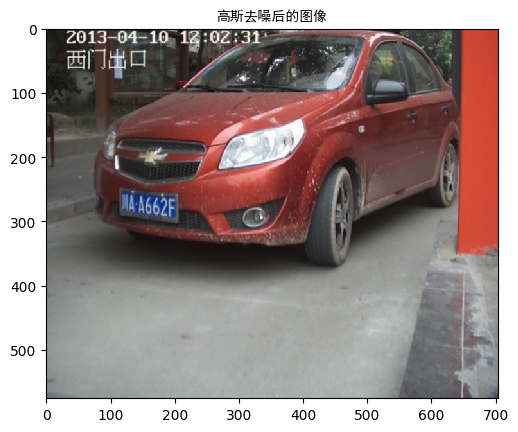

是否继续分步显示？ Yes请输入1，No请输入0： 0


len(contours) 8
peak less 1: 1
车牌颜色： blue
预测的车牌字符： ['川', 'A', 'A', '6', '6', '2', 'F']


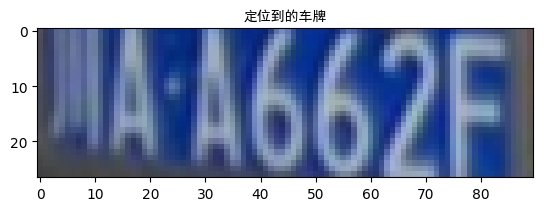

In [5]:
    # 解压原始数据到指定路径
    unzip_data(src_path,target_path)
    # unrar_data(src_path,target_path)
    img = cv2.imread(DataPath + r'imgs/test/cAA662F.jpg')  
    cardPredictor = CardPredictor()
    cardPredictor.train_svm()
    cardPredictor.save_traindata()
    predict_result, roi, card_color = cardPredictor.predict(img)
    if predict_result:
        print("车牌颜色：", card_color)
        print('预测的车牌字符：', predict_result)
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        plt.title('定位到的车牌',fontproperties = font)      
        plt.imshow(roi)
        plt.show()
    else:
        print("返回了空值，预测失败！")